# Task 7. Parallel Integral

In [71]:
%%writefile mpi_integral.py

from datetime import datetime
import numpy as np
from mpi4py import MPI
from sympy import *
    

def get_trapezoid_area(x1, x2, y1, y2):
    return (x2 - x1)*(y1 + y2)/2

startTime = datetime.now()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.size

t = Symbol('t')
f = 1/sqrt(1 + t**2) + t**3
f_diff = diff(f, t)

f = lambdify(t, f)
f_diff = lambdify(t, f_diff)

N = 100000
x = np.linspace(0, 100, N)
y = f_diff(x)

sub_area = 0
n_b = int(rank*(N - 1)/size)
n_t = int((rank + 1)*(N - 1)/size)

for i in range(n_b, n_t):
    i = int(i)
    x1, x2 = x[i], x[i+1]
    y1, y2 = y[i], y[i+1]
    sub_area += get_trapezoid_area(x1, x2, y1, y2)
    
area = comm.reduce(sub_area, op=MPI.SUM, root=0)

if rank == 0:
    print(datetime.now() - startTime)

Overwriting mpi_integral.py


In [2]:
proc = [1, 2, 3, 4]

In [4]:
import mpi4py
import numpy as np
import matplotlib.pyplot as plt

bif_time = []

for i in proc:
    time = !mpiexec -np {i} python mpi_integral.py
    bif_time.append(float(time[0][-8:]))
    print (time[0][-8:])

[]


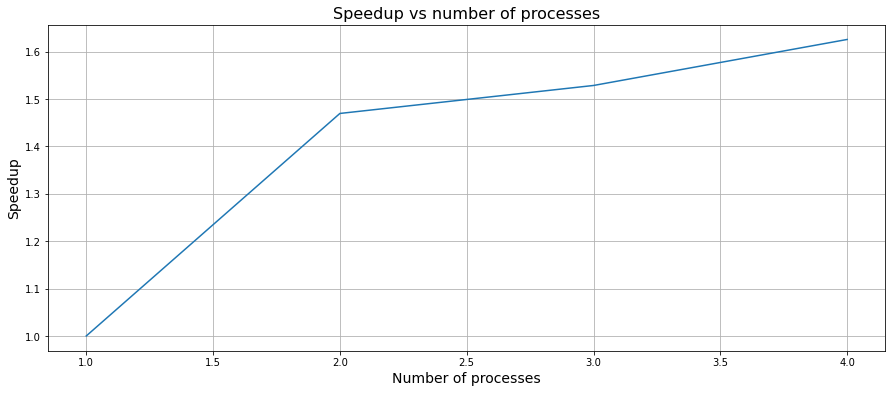

In [74]:
plt.figure(figsize=(15, 6))
plt.plot(proc, bif_time[0] / np.array(bif_time))
plt.title('Speedup vs number of processes', size=16)
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);

# Task 8. Parallel Shift

In [1]:
# !conda install tqdm -y

In [37]:
%%writefile shift.py

from mpi4py import MPI
from PIL import Image
import numpy as np
from matplotlib import image
from matplotlib import pyplot
from datetime import datetime

import argparse
parser = argparse.ArgumentParser()
parser.add_argument("-i", "--input", type=str, default='catt.jpg', help="Name of input image.")
parser.add_argument("-o", "--output", type=str, default='cat.jpg', help="Name of output image.")
parser.add_argument("-s", "--shift", type=int, default=1, help="How many 1 pixel shifts should be done.")
args = parser.parse_args()

image_name = args.input

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    image_full = np.array(Image.open(image_name), dtype=np.uint8)
    image_shape = np.asarray(image_full.shape, dtype=np.int32)
    start = datetime.now()
else:
    image_full = None
    image_shape = np.empty(3, dtype=np.int32)
    
comm.Bcast(image_shape, root=0)

split_index = np.linspace(0, image_shape[0], size+1, endpoint=True, dtype=np.int32)
piece_sizes = np.diff(split_index)

extra_size = np.prod(image_shape[1:])
counts = piece_sizes * extra_size
displacements = split_index[:-1] * extra_size

recv_buff = np.zeros((piece_sizes[rank], *image_shape[1:]), dtype=np.uint8)
send_buff = image_full if rank == 0 else None

# S - numpy, v - vectors, different length
comm.Scatterv([send_buff, counts, displacements, MPI.BYTE], recv_buff, root=0)

data = recv_buff
right = (rank + 1) % size
left  = (size + rank - 1) % size
send_row = np.empty((1, *image_shape[1:]), dtype=np.uint8) #int32
recv_row = np.empty((1, *image_shape[1:]), dtype=np.uint8) #int32

for i in range(args.shift):
    send_row = data[-1] # down row
    data = np.roll(data, 1, axis=0)
    
    comm.Send([send_row, MPI.BYTE], dest=right)  # send to down
    comm.Recv([recv_row, MPI.BYTE], source=left) # recieve from up
    
    data[0] = recv_row
    
data_from_proc = np.empty(tuple(image_shape), dtype=np.uint8) if rank == 0 else None
comm.Gatherv(data, [data_from_proc, counts, displacements, MPI.BYTE], root=0)
    
if rank == 0:
    print((datetime.now()-start).total_seconds())
    img = Image.fromarray(data_from_proc)
    img.save(args.output)

Overwriting shift.py


0.008003


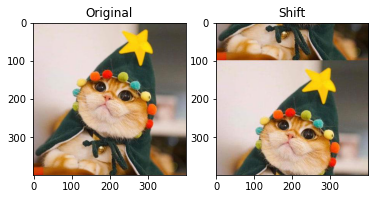

In [38]:
import mpi4py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

!mpiexec -np 3 python shift.py -i 'catt.jpg' -s 100

plt.subplot(121)
image = Image.open('catt.jpg')
plt.imshow(image)
plt.title("Original")
plt.subplot(122)
image = Image.open('cat.jpg')
plt.imshow(image)
plt.title("Shift")
plt.show()

In [4]:
proc = [1, 2, 3, 4]

In [48]:
import mpi4py
import numpy as np
import matplotlib.pyplot as plt

bif_time = []

for i in proc:
    time = !mpiexec -np {i} python shift.py -i 'catt.jpg' -s 400
    bif_time.append(float(time[0][-8:]))
    print (time[0][-8:])

0.012674
0.011004
0.011464
0.012316


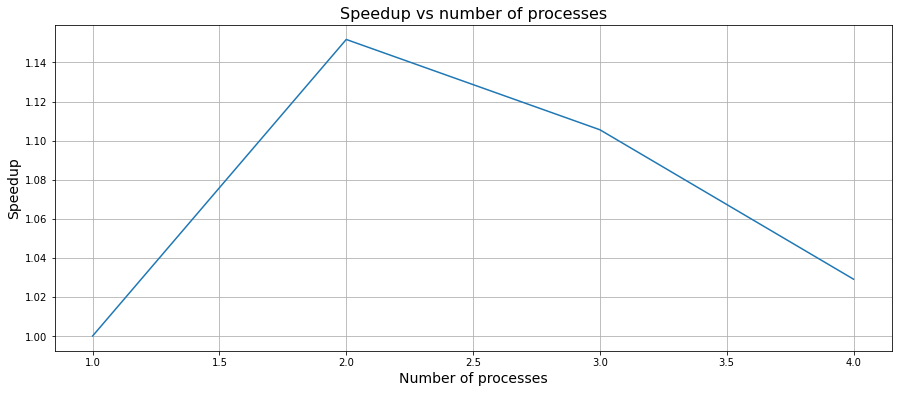

In [49]:
plt.figure(figsize=(15, 6))
plt.plot(proc, bif_time[0] / np.array(bif_time))
plt.title('Speedup vs number of processes', size=16)
plt.xlabel('Number of processes', size=14)
plt.ylabel('Speedup', size=14)
plt.grid(True);

# Task 9. Game of Life

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import tqdm
from scipy.signal import convolve2d
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
def step(M):
    K = np.ones((3, 3), dtype=int)
    K[1, 1] = 0
    
    num_alive = convolve2d(M, K, mode='same')
    dead2alive = (M == 0) & (num_alive == 3)
    alive2alive = (M == 1) & (1 < num_alive) & (num_alive < 4)
    M_res = np.zeros_like(M)
    M_res[dead2alive] = 1
    M_res[alive2alive] = 1
    
    return M_res, np.sum(M_res)

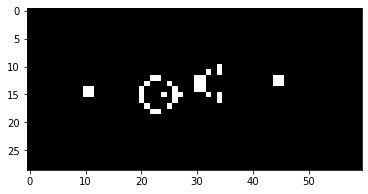

In [3]:
glider = np.array(
    [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,],
    [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
    [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
    [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]])

glider = np.pad(glider, ((10,10),(10,10)))

plt.imshow(glider, cmap='gray');

In [4]:
M = np.random.randint(0, 2, (40,40), dtype=np.uint8)
results = []

with imageio.get_writer('convey.gif', mode='I', fps=10) as writer:
    for i in tqdm.trange(200):
        M, count = step(M)
        results.append(count)
        plt.imshow(M, cmap='gray')
        plt.savefig('tmp.png')
        plt.close()
        writer.append_data(imageio.imread('tmp.png'))

100%|██████████| 200/200 [00:15<00:00, 12.80it/s]


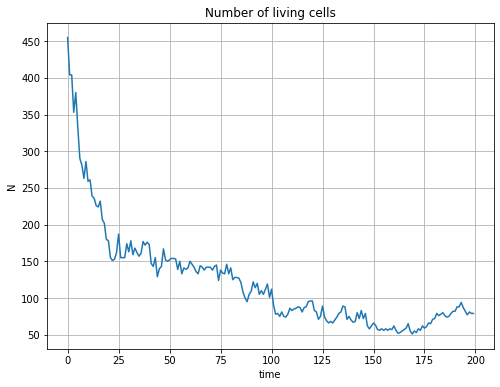

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(results)
plt.title('Number of living cells')
plt.xlabel('time')
plt.grid(True)
plt.ylabel('N');

In [6]:
M = glider
results = []

with imageio.get_writer('convey_glider.gif', mode='I', fps=10) as writer:
    for i in tqdm.trange(200):
        M, count = step(M)
        results.append(count)
        plt.imshow(M, cmap='gray')
        plt.savefig('tmp.png')
        plt.close()
        writer.append_data(imageio.imread('tmp.png'))

100%|██████████| 200/200 [00:16<00:00, 12.38it/s]


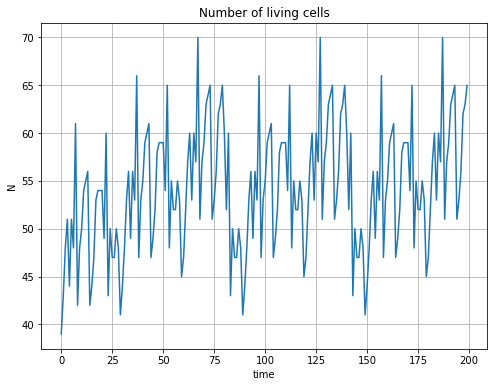

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(results)
plt.title('Number of living cells')
plt.xlabel('time')
plt.grid(True)
plt.ylabel('N');